In [1]:
import pickle
import pandas as pd
import numpy as np
import datetime as dt
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
movie_df = pickle.load(open('clean_movie_df.pickle', 'rb'))
movie_df = movie_df[movie_df.theaters>1500]

In [12]:
movie_df.release = pd.to_datetime(movie_df.release)
movie_df[movie_df.release >= dt.datetime(2019,1,1)].budget.isna().value_counts()

False    107
True      21
Name: budget, dtype: int64

In [13]:
#read holidays csv
holidays = pd.read_csv('usholidays.csv')

#convert all dates to datetime/timestamp
movie_df.release = pd.to_datetime(movie_df.release)
holidays.loc[:,'Date'] = pd.to_datetime(holidays.Date)

#filter out holiday dates before the year 2000
holidays = holidays[holidays.Date >= dt.datetime(2000,1,1)].Date

#########################IF I have Time: Try to replace this with numpy array combinations
def find_closest_holiday(date):
    """
    Finds the days to the nearest US Federal Holiday
    args:
    date (timestamp)
    returns:
    nearest_hol (int) days to the nearest holiday
    """
    nearest_hol = 365
    for hol in holidays:
        d = abs((hol - date).days)
        if d < nearest_hol:
            nearest_hol = d
    return nearest_hol

movie_df['holiday_distance'] = movie_df.release.map(find_closest_holiday)
#movie_df.drop(columns='release', inplace=True)

In [14]:
movie_df['year'] = movie_df.release.map(lambda x: x.year-2000)

In [15]:
movie_df.rename(columns={'index':'title'}, inplace=True)

In [16]:
columns_to_count = ['Director', 
                    'distr', 
                    'Composer', 
                    'Cinematographer', 
                    'Editor', 
                    'Production Designer', 
                    'Writer', 
                    'Producer', 
                    'Actors']

for crew in columns_to_count:
    # Do explode by Groupby to get separate columns
    current_crew = movie_df[['title', crew]][crew].str.split(', ').explode()
    current_crew = pd.DataFrame(current_crew)
    current_crew.merge(movie_df.title, left_index=True, right_index=True)
    current_crew = current_crew.merge(movie_df[['title', 'gross_dom', 'budget', 'release']], left_index=True, right_index=True, how='left')
    current_crew.drop_duplicates(inplace=True)

    current_crew = current_crew.sort_values(by=[crew, 'release'])
    current_crew.reset_index(drop=True, inplace=True)
    
    # .expanding(2) to create rolling window starting at two maximum quantities
    dom_mean = current_crew.groupby(crew, as_index=True).gross_dom.expanding(2).mean()
    dom_max = current_crew.groupby(crew, as_index=True).gross_dom.expanding(2).max()
    budg_mean = current_crew.groupby(crew, as_index=True).budget.expanding(2).mean()
    budg_max = current_crew.groupby(crew, as_index=True).budget.expanding(2).max()
    past_data = pd.DataFrame(zip(current_crew.title, dom_mean, dom_max, budg_mean, budg_max), columns=['title', 'cum_dom_mean', 'cum_dom_max', 'cum_budg_mean', 'cum_budg_max'])
    past_data.fillna(value=0, inplace=True)
    
    current_crew = current_crew.merge(past_data, on='title')
    current_crew = current_crew.groupby('title', as_index=False).agg({'cum_dom_mean':'mean', 'cum_dom_max':'max', 'cum_budg_mean':'mean', 'cum_budg_max':'max'})
    
    current_crew.columns=['title', crew+'_mean_dom', crew+'_max_dom', crew+'_mean_budg', crew+'_max_budg']
    
    movie_df = movie_df.merge(current_crew, on='title', how='left')

In [17]:
movie_df.columns

Index(['title', 'link_stub', 'release', 'theaters', 'desc', 'distr', 'opening',
       'budget', 'mpaa', 'runtime', 'genres', 'gross_dom', 'gross_inter',
       'gross_world', 'Director', 'Writer', 'Producer', 'Composer',
       'Cinematographer', 'Editor', 'Production Designer', 'Actors',
       'holiday_distance', 'year', 'Director_mean_dom', 'Director_max_dom',
       'Director_mean_budg', 'Director_max_budg', 'distr_mean_dom',
       'distr_max_dom', 'distr_mean_budg', 'distr_max_budg',
       'Composer_mean_dom', 'Composer_max_dom', 'Composer_mean_budg',
       'Composer_max_budg', 'Cinematographer_mean_dom',
       'Cinematographer_max_dom', 'Cinematographer_mean_budg',
       'Cinematographer_max_budg', 'Editor_mean_dom', 'Editor_max_dom',
       'Editor_mean_budg', 'Editor_max_budg', 'Production Designer_mean_dom',
       'Production Designer_max_dom', 'Production Designer_mean_budg',
       'Production Designer_max_budg', 'Writer_mean_dom', 'Writer_max_dom',
       'Writer_mea

In [18]:
movie_df.corrwith(movie_df.gross_dom).sort_values(ascending=False)

gross_dom                        1.000000
gross_world                      0.940525
opening                          0.940373
gross_inter                      0.860486
Producer_mean_dom                0.675056
Writer_mean_dom                  0.651451
Actors_mean_dom                  0.642154
budget                           0.638670
Director_max_dom                 0.612842
Editor_mean_dom                  0.609631
Writer_max_dom                   0.606830
Director_mean_dom                0.599603
Producer_max_dom                 0.550229
Production Designer_mean_dom     0.545456
Production Designer_max_dom      0.531834
Editor_max_dom                   0.529677
Cinematographer_mean_dom         0.528765
Composer_mean_dom                0.523840
Writer_mean_budg                 0.505506
Cinematographer_max_dom          0.502652
Composer_max_dom                 0.496976
Producer_mean_budg               0.489476
Writer_max_budg                  0.471140
Director_max_budg                0

# Deal with nan

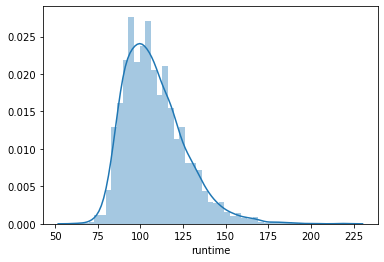

In [19]:
# fill runtime nans with average/mean
sns.distplot(movie_df.runtime)

In [20]:
# fill na with median
movie_df.runtime.fillna(value=movie_df.runtime.median(), inplace=True)

In [21]:
movie_df.columns

Index(['title', 'link_stub', 'release', 'theaters', 'desc', 'distr', 'opening',
       'budget', 'mpaa', 'runtime', 'genres', 'gross_dom', 'gross_inter',
       'gross_world', 'Director', 'Writer', 'Producer', 'Composer',
       'Cinematographer', 'Editor', 'Production Designer', 'Actors',
       'holiday_distance', 'year', 'Director_mean_dom', 'Director_max_dom',
       'Director_mean_budg', 'Director_max_budg', 'distr_mean_dom',
       'distr_max_dom', 'distr_mean_budg', 'distr_max_budg',
       'Composer_mean_dom', 'Composer_max_dom', 'Composer_mean_budg',
       'Composer_max_budg', 'Cinematographer_mean_dom',
       'Cinematographer_max_dom', 'Cinematographer_mean_budg',
       'Cinematographer_max_budg', 'Editor_mean_dom', 'Editor_max_dom',
       'Editor_mean_budg', 'Editor_max_budg', 'Production Designer_mean_dom',
       'Production Designer_max_dom', 'Production Designer_mean_budg',
       'Production Designer_max_budg', 'Writer_mean_dom', 'Writer_max_dom',
       'Writer_mea

In [22]:
# if the row has a null value for the budget
# the average budget of the crew/distr should reflect the overall budget as well

budget_list = ['Director_mean_budg',
               'distr_mean_budg',
               'Composer_mean_budg',
               'Cinematographer_mean_budg',
               'Editor_mean_budg',
               'Production Designer_mean_budg',
               'Writer_mean_budg',
               'Producer_mean_budg',
               'Actors_mean_budg']

    
dom_list = ['average_prior_Director_dom',
            'average_prior_distr_dom',
            'average_prior_Composer_dom',
            'average_prior_Cinematographer_dom',
            'average_prior_Editor_dom',
            'average_prior_Production Designer_dom',
            'average_prior_Writer_dom',
            'average_prior_Producer_dom',
            'average_prior_Actors_dom']
    
movie_df['average_row_budget'] = np.mean(movie_df[budget_list], axis=1)
movie_df.budget.fillna(value=movie_df.average_row_budget, axis=0, inplace=True)


In [23]:
movie_df['day_of_year'] = movie_df.release.map(lambda x : x.dayofyear)

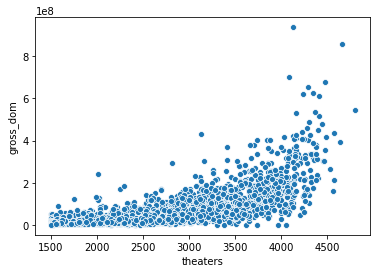

In [24]:
# theaters and gross_dom have a logistic relationship
sns.scatterplot(x='theaters', y='gross_dom', data=movie_df);

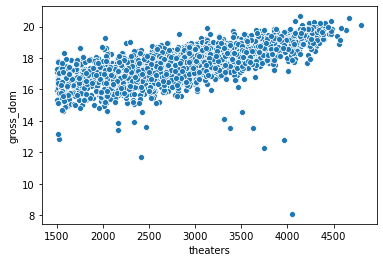

In [25]:
# log(y) = x looks linear
sns.scatterplot(x=movie_df.theaters, y=movie_df.gross_dom.map(np.log))

In [26]:
# standardize theaters value and raise to the exponent
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
movie_df.theaters = scaler.fit_transform(movie_df[['theaters']])
movie_df['theaters_exp'] = movie_df.theaters.map(np.exp)

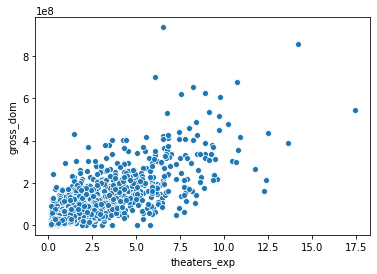

In [27]:
sns.scatterplot(x='theaters_exp', y='gross_dom', data=movie_df)

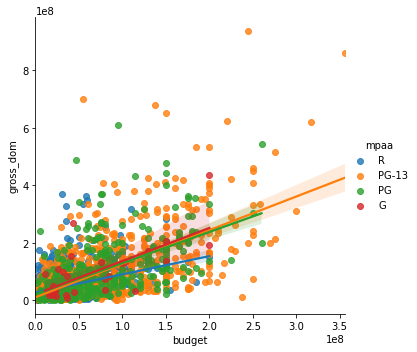

In [28]:
sns.lmplot(x='budget', y='gross_dom', data=movie_df, hue='mpaa')

In [29]:
#get median values for distr in nan opening
med_nan_dict = {i : movie_df[movie_df.distr==i].opening.median() for i in movie_df.distr.unique()}
 

for idx, o in enumerate(movie_df.opening): 
    if np.isnan(o):
        key = movie_df.distr.iloc[idx]
        movie_df.opening.iloc[idx] = med_nan_dict[key]

/Users/andrew/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [30]:
# group day of year, budget, runtime into categories
# day of year
# Winter - Dec 21 to March 20 -- 355, 79
# Spring - March 20 to June 20 -- 79, 171
# Summer - June 20 to September 22 171, 265
# Fall - September 22 to Dec 21 265, 355
# Budget 
# Low < 29092651
# 29092651 < Medium < 52000000
# 52000000 < High
# Runtime
# Short < 60
# Normal < 60-120
# Long > 120

In [31]:
def seasons(day):
    if day < 79 or day > 355:
        return 'winter'
    elif day < 171:
        return 'spring'
    elif day < 265:
        return 'summer'
    else:
        return 'fall'
    
def budget_quality(bud):
    if bud < 29092651: #33 quantile
        return 'low'
    elif bud > 52000000: #66 quantile
        return 'high'
    else:
        return 'medium'

def runtime_quality(r):
    if r < 90:
        return 'short'
    elif r > 120:
        return 'long'
    else:
        return 'normal'
    
movie_df['seasons'] = movie_df.day_of_year.map(seasons)
movie_df['budget_cat'] = movie_df.budget.map(budget_quality)
movie_df['runtime_cat'] = movie_df.runtime.map(runtime_quality)

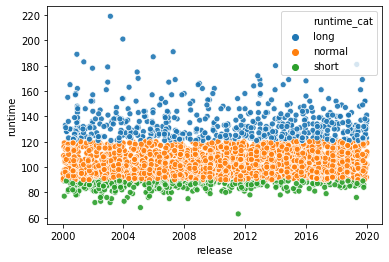

In [32]:
sns.scatterplot(x='release', y='runtime', data=movie_df, hue='runtime_cat', alpha=0.9)

In [1]:
# Generate Target of ROI
# movie_df['roi'] = (movie_df.gross_dom-movie_df.budget)/movie_df.budget

In [ ]:
'Action, Adventure, Thriller'

# Movie Genre and MPAA Dummies

In [33]:
def dumdumdum(movie_df):
    #get dummies for genres
    movie_df.set_index('title', inplace=True)
    movie_df = movie_df.merge(movie_df.genres.str.get_dummies(sep=', '), left_index=True, right_index=True, );
    
    #get dummies for mpaa rating
    movie_df = pd.get_dummies(movie_df, columns=['mpaa', 'seasons', 'budget_cat', 'runtime_cat'], drop_first=False)
    return movie_df

movie_df = movie_df.dropna(axis=0)
movie_df = dumdumdum(movie_df)

In [34]:
prepped = movie_df
with open('processed_movie_df.pickle', 'wb') as to_write:
    pickle.dump(prepped, to_write)

In [30]:
movie_df.columns

Index(['link_stub', 'release', 'theaters', 'desc', 'distr', 'opening',
       'budget', 'runtime', 'genres', 'gross_dom', 'gross_inter',
       'gross_world', 'Director', 'Writer', 'Producer', 'Composer',
       'Cinematographer', 'Editor', 'Production Designer', 'Actors',
       'holiday_distance', 'year', 'average_prior_Director_dom',
       'average_prior_Director_budget', 'average_prior_distr_dom',
       'average_prior_distr_budget', 'average_prior_Composer_dom',
       'average_prior_Composer_budget', 'average_prior_Cinematographer_dom',
       'average_prior_Cinematographer_budget', 'average_prior_Editor_dom',
       'average_prior_Editor_budget', 'average_prior_Production Designer_dom',
       'average_prior_Production Designer_budget', 'average_prior_Writer_dom',
       'average_prior_Writer_budget', 'average_prior_Producer_dom',
       'average_prior_Producer_budget', 'average_prior_Actors_dom',
       'average_prior_Actors_budget', 'average_row_budget', 'day_of_year',
      

In [34]:
movie_df.runtime.describe().min() < 60

True

In [35]:
movie_df.roi.describe()

count    2890.000000
mean        3.288855
std       133.915431
min        -0.996656
25%        -0.508387
50%         0.000677
75%         0.844988
max      7193.587333
Name: roi, dtype: float64

In [36]:
movie_df.loc[movie_df.roi==movie_df.roi.max()]

,link_stub,release,theaters,desc,distr,opening,budget,runtime,genres,gross_dom,...,seasons_fall,seasons_spring,seasons_summer,seasons_winter,budget_cat_high,budget_cat_low,budget_cat_medium,runtime_cat_long,runtime_cat_normal,runtime_cat_short
title,,,,,,,,,,,,,,,,,,,,,
Paranormal Activity,/release/rl2355725825/?ref_=bo_yld_table_30,2009-09-25,0.243259,"After moving into a suburban home, a couple be...",Paramount Pictures,15451981.0,15000.0,86.0,"Horror, Mystery",107918810,...,1,0,0,0,0,1,0,0,0,1


In [37]:
movie_df.corrwith(movie_df.roi).sort_values(ascending=False).head(10)

roi                          1.000000
runtime_cat_short            0.057669
Horror                       0.056905
Mystery                      0.051346
budget_cat_low               0.034928
seasons_fall                 0.028915
mpaa_R                       0.025454
gross_dom_Actors             0.021707
gross_dom_Cinematographer    0.019851
gross_dom_Editor             0.016520
dtype: float64

In [38]:
begin_columns = begin_columns.values

NameError: name 'begin_columns' is not defined

In [ ]:
begin_columns = np.append(begin_columns, 'roi')

In [ ]:
sns.pairplot(movie_df[movie_df.roi<5][begin_columns])

In [ ]:
begin_columns = begin_columns.tolist()

In [ ]:
begin_columns[0] = 'title'

In [ ]:
movie_df.columns

In [ ]:
sns.boxplot(movie_df.gross_dom)

In [ ]:
movie_df[movie_df.gross_dom>2.5e8].describe()

In [ ]:
movie_df.head()

# Scratchpad for Making Historical Dictionary:

In [176]:
curr=movie_df[['title','Writer']]



In [205]:
# Explode the dataset
curr_crew = []
for row in range(len(curr)):
    movietitle = curr.iloc[row][0]
    try:
        for name in curr.iloc[row][1].split(','):
            name = name.strip()
            curr_crew.append((movietitle, name))
    except:
        pass
curr_crew = pd.DataFrame(curr_crew, columns=['title', 'Writer'])

In [207]:
curr_crew.drop_duplicates(inplace=True)
curr_crew=curr_crew.merge(movie_df[['title', 'gross_dom', 'budget', 'release']], on='title', how='left')

In [236]:
curr_crew

,title,Writer,gross_dom,budget,release
2247,Stan & Ollie,'A.J.' Marriot,5470235,NaN,2018-12-28
2469,The Tigger Movie,A.A. Milne,45554533,30000000.0,2000-02-11
5193,Piglet's Big Movie,A.A. Milne,23103423,NaN,2003-03-21
2476,Pooh's Heffalump Movie,A.A. Milne,18098433,20000000.0,2005-02-11
3670,Winnie the Pooh,A.A. Milne,26692846,30000000.0,2011-07-15
...,...,...,...,...,...
8530,Machete,Álvaro Rodríguez,26593646,10500000.0,2010-09-03
1248,Babylon A.D.,Éric Besnard,22532572,70000000.0,2008-08-29
5062,I Think I Love My Wife,Éric Rohmer,12550605,11000000.0,2007-03-16
3070,The Upside,Éric Toledano,108252517,37500000.0,2019-01-11


In [57]:
# remove null or nan quantities
curr_crew.set_index('Writer', inplace=True)
curr_crew = curr_crew.drop('nan').reset_index()



In [ ]:
columns_to_count = ['Director', 
                    'distr', 
                    'Composer', 
                    'Cinematographer', 
                    'Editor', 
                    'Production Designer', 
                    'Writer', 
                    'Producer', 
                    'Actors']
#Gets number of times the crewmember or distributor works on something in the dataframe.  
#Larger n may associate with more experience
for crew in columns_to_count:
    
    """########### portfolios really have little to no correlation with gross_dom target
    ########### But the portfolio value is useful for determining how to fill nulls
    curr_portfolio = movie_df[crew].value_counts().reset_index()
    curr_portfolio = pd.DataFrame(curr_portfolio).rename(columns={'index':crew, crew:crew+'_portfolio'})
    movie_df = movie_df.merge(curr_portfolio, left_on=crew, right_on=crew)"""
    
    # Some movies have multiple people in the same row.  Split them to get their individual average amounts 
    curr = movie_df[['title', crew]]
    
    # make list to append unique title/name combination
    curr_crew = []
    for row in range(len(curr)):
        movietitle = curr.iloc[row][0]
        try:
            for name in curr.iloc[row][1].split(','):
                name = name.strip()
                curr_crew.append((movietitle, name))
        except:
            pass
    curr_crew = pd.DataFrame(curr_crew, columns=['title', crew])
    curr_crew.drop_duplicates(inplace=True)
    
    curr_crew=curr_crew.merge(movie_df[['title', 'gross_dom', 'budget', 'release']], on='title')
    
    # remove null or nan quantities
    curr_crew.set_index(crew, inplace=True)
    try:
        curr_crew = curr_crew.drop('nan').reset_index()
    except:
        curr_crew = curr_crew.reset_index()
    
    # get count of total times the crew shows up
    crew_counts = curr_crew[crew].value_counts()

    # sort alphabetically to group the crew members
    # then sort by release date to put them in order
    curr_crew = curr_crew.sort_values(by=[crew, 'release'])
    unique_members = curr_crew[crew].unique()
    
    prev = []
    prev_gross_dom = []
    prev_budget = []
    for name in unique_members:
        # generate list with number of times the crew member has shown up prior to the current row (Since 2000)
        prev.extend([x for x in range(crew_counts.loc[name])])
        # create slices based on position and get sum of previous iterations to get cumulative sum prior to current movie
        for c in range(crew_counts.loc[name]):
            pg = curr_crew[curr_crew[crew]==name][:c]['gross_dom'].sum()
            pb = curr_crew[curr_crew[crew]==name][:c]['budget'].sum()
            prev_gross_dom.append(pg)
            prev_budget.append(pb)
    
    # add each of the above lists as columns on the curr_crew df
    curr_crew['n_previous'] = prev
    curr_crew['previous_cumulative_domestic'] = prev_gross_dom
    curr_crew['previous_cumulative_budget'] = prev_budget
    
    curr_crew.reset_index(drop=True, inplace=True)
    

    # get the crew's prior average
    curr_crew['average_prior_{}_dom'.format(crew)] = curr_crew['previous_cumulative_domestic']/curr_crew['n_previous']
    curr_crew['average_prior_{}_budget'.format(crew)] = curr_crew['previous_cumulative_budget']/curr_crew['n_previous']
    
    # divide by zero error (no prior history)
    curr_crew['average_prior_{}_dom'.format(crew)].fillna(value=0, inplace=True)
    curr_crew['average_prior_{}_budget'.format(crew)].fillna(value=0, inplace=True)
    
    # Averages the writer's prior averages who share the same movie title
    curr_crew = curr_crew.groupby('title', as_index=False).aggregate({'average_prior_{}_dom'.format(crew): 'mean', 'average_prior_{}_budget'.format(crew): 'mean'})
    # merge movie_df and curr_crew
    # how='left' to presrve values from the left df (movie_df) and fills in nans 
    movie_df = movie_df.merge(curr_crew, on='title', how='left')

    

In [308]:
# Do explode by Groupby
test2 = movie_df[['title', 'Writer']].Writer.str.split(', ').explode()
test2 = pd.DataFrame(test2)
test2.merge(movie_df.title, left_index=True, right_index=True)
test2 = test2.merge(movie_df[['title', 'gross_dom', 'budget', 'release']], left_index=True, right_index=True, how='left')
test2.drop_duplicates(inplace=True)

test2 = test2.sort_values(by=['Writer', 'release'])
test2.reset_index(drop=True, inplace=True)

In [309]:
test2

,Writer,title,gross_dom,budget,release
0,'A.J.' Marriot,Stan & Ollie,5470235,NaN,2018-12-28
1,A.A. Milne,The Tigger Movie,45554533,30000000.0,2000-02-11
2,A.A. Milne,Piglet's Big Movie,23103423,NaN,2003-03-21
3,A.A. Milne,Pooh's Heffalump Movie,18098433,20000000.0,2005-02-11
4,A.A. Milne,Winnie the Pooh,26692846,30000000.0,2011-07-15
...,...,...,...,...,...
8657,Álvaro Rodríguez,Machete,26593646,10500000.0,2010-09-03
8658,Éric Besnard,Babylon A.D.,22532572,70000000.0,2008-08-29
8659,Éric Rohmer,I Think I Love My Wife,12550605,11000000.0,2007-03-16
8660,Éric Toledano,The Upside,108252517,37500000.0,2019-01-11


In [310]:
# .expanding(2) to create rolling window starting at two maximum quantities
dom_mean = test2.groupby('Writer', as_index=True).gross_dom.expanding(2).mean()
dom_max = test2.groupby('Writer', as_index=True).gross_dom.expanding(2).max()
budg_mean = test2.groupby('Writer', as_index=True).budget.expanding(2).mean()
budg_max = test2.groupby('Writer', as_index=True).budget.expanding(2).max()

In [311]:
cum_data2 = pd.DataFrame(zip(dom_mean, dom_max, budg_mean, budg_max), columns=['cum_dom_mean', 'cum_dom_max', 'cum_budg_mean', 'cum_budg_max'], index=test2.index).fillna(value=0)

In [312]:
test2 = test2.merge(cum_data2, left_index=True, right_index=True)
test2 = test2.groupby('title', as_index=False).agg({'cum_dom_mean':'mean', 'cum_dom_max':'mean', 'cum_budg_mean':'mean', 'cum_budg_max':'mean'})
test2.columns = ['title', 'Writer_mean_dom', 'Writer_max_dom', 'Writer_mean_budg', 'Writer_max_budg']
test2

,title,Writer_mean_dom,Writer_max_dom,Writer_mean_budg,Writer_max_budg
0,10 Cloverfield Lane,1.115048e+07,2.402767e+07,1.383333e+06,1.666667e+06
1,"10,000 BC",7.038125e+07,9.337040e+07,5.750000e+07,6.250000e+07
2,102 Dalmatians,4.760977e+07,6.843673e+07,4.300000e+07,5.200000e+07
3,12 Rounds,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,12 Strong,8.023992e+07,1.434286e+08,5.827778e+07,7.933333e+07
...,...,...,...,...,...
3280,Zootopia,1.365834e+08,1.780678e+08,4.125000e+07,4.312500e+07
3281,xXx,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3282,xXx: Return of Xander Cage,3.564695e+07,7.105469e+07,3.875000e+07,4.250000e+07
3283,xXx: State of the Union,4.224583e+07,7.105469e+07,0.000000e+00,0.000000e+00


In [306]:
len(movie_df)

3285

In [245]:
# sort alphabetically to group the crew members
# then sort by release date to put them in order
curr_crew = curr_crew.sort_values(by=['Writer', 'release'])
unique_writers = curr_crew.Writer.unique()

In [287]:
curr_crew

,title,Writer,gross_dom,budget,release
2247,Stan & Ollie,'A.J.' Marriot,5470235,NaN,2018-12-28
2469,The Tigger Movie,A.A. Milne,45554533,30000000.0,2000-02-11
5193,Piglet's Big Movie,A.A. Milne,23103423,NaN,2003-03-21
2476,Pooh's Heffalump Movie,A.A. Milne,18098433,20000000.0,2005-02-11
3670,Winnie the Pooh,A.A. Milne,26692846,30000000.0,2011-07-15
...,...,...,...,...,...
8530,Machete,Álvaro Rodríguez,26593646,10500000.0,2010-09-03
1248,Babylon A.D.,Éric Besnard,22532572,70000000.0,2008-08-29
5062,I Think I Love My Wife,Éric Rohmer,12550605,11000000.0,2007-03-16
3070,The Upside,Éric Toledano,108252517,37500000.0,2019-01-11


In [286]:
# .expanding(2) to create rolling window starting at two maximum quantities
dom_mean = curr_crew.groupby('Writer', as_index=True).gross_dom.expanding(2).mean()
dom_max = curr_crew.groupby('Writer', as_index=True).gross_dom.expanding(2).max()
budg_mean = curr_crew.groupby('Writer', as_index=True).budget.expanding(2).mean()
budg_max = curr_crew.groupby('Writer', as_index=True).budget.expanding(2).max()

In [243]:
cum_data = pd.DataFrame(zip(dom_mean, dom_max, budg_mean, budg_max), columns=['cum_dom_mean', 'cum_dom_max', 'cum_budg_mean', 'cum_budg_max'], index=curr_crew.index)

In [244]:
cum_data

,cum_dom_mean,cum_dom_max,cum_budg_mean,cum_budg_max
2247,NaN,NaN,NaN,NaN
2469,NaN,NaN,NaN,NaN
5193,3.432898e+07,45554533.0,NaN,NaN
2476,2.891880e+07,45554533.0,2.500000e+07,30000000.0
3670,2.836231e+07,45554533.0,2.666667e+07,30000000.0
...,...,...,...,...
8530,2.375641e+07,26593646.0,NaN,NaN
1248,NaN,NaN,NaN,NaN
5062,NaN,NaN,NaN,NaN
3070,NaN,NaN,NaN,NaN


In [172]:
budg_max.reset_index().set_index('idx', drop=True)

KeyError: "None of ['idx'] are in the columns"

In [174]:
curr_crew.index

Int64Index([2235, 2456, 5171, 2463, 3651, 1293, 8190,  320,  899, 3805,
            ...
            7096, 1888, 2074, 3550, 1052, 8496, 1241, 5040, 3054, 3093],
           dtype='int64', length=8628)

In [140]:
test = test.reset_index().set_index('idx', drop=True)

In [58]:
# get count of total times the crew shows up
crew_counts = curr_crew.Writer.value_counts()

In [142]:
curr_crew.merge(test.gross_dom, left_index=True, right_index=True)

,Writer,title,gross_dom_x,budget,release,gross_dom_y
2235,'A.J.' Marriot,Stan & Ollie,5470235,NaN,2018-12-28,NaN
2456,A.A. Milne,The Tigger Movie,45554533,30000000.0,2000-02-11,NaN
5171,A.A. Milne,Piglet's Big Movie,23103423,NaN,2003-03-21,3.432898e+07
2463,A.A. Milne,Pooh's Heffalump Movie,18098433,20000000.0,2005-02-11,2.891880e+07
3651,A.A. Milne,Winnie the Pooh,26692846,30000000.0,2011-07-15,2.836231e+07
...,...,...,...,...,...,...
8496,Álvaro Rodríguez,Machete,26593646,10500000.0,2010-09-03,2.375641e+07
1241,Éric Besnard,Babylon A.D.,22532572,70000000.0,2008-08-29,NaN
5040,Éric Rohmer,I Think I Love My Wife,12550605,11000000.0,2007-03-16,NaN
3054,Éric Toledano,The Upside,108252517,37500000.0,2019-01-11,NaN


In [46]:
""""prev = []
prev_gross_dom = []
prev_budget = []
for name in unique_writers:
    # generate list with number of times the crew member has shown up prior to the current row (Since 2000)
    prev.extend([x for x in range(crew_counts.loc[name])])
    # create slices based on position and get sum of previous iterations to get cumulative sum prior to current movie
    for c in range(crew_counts.loc[name]):
        pg = curr_crew[curr_crew.Writer==name][:c]['gross_dom'].sum()
        pb = curr_crew[curr_crew.Writer==name][:c]['budget'].sum()
        prev_gross_dom.append(pg)
        prev_budget.append(pb)""""

In [47]:
# add each of the above rows as columns on the curr_crew df
curr_crew['n_previous'] = prev
curr_crew['previous_cumulative_domestic'] = prev_gross_dom
curr_crew['previous_cumulative_budget'] = prev_budget

In [19]:
curr_crew.reset_index(drop=True, inplace=True)

In [48]:
# get the writer's prior average
curr_crew['average_prior_writer_dom'] = curr_crew['previous_cumulative_domestic']/curr_crew['n_previous']
curr_crew['average_prior_writer_budget'] = curr_crew['previous_cumulative_budget']/curr_crew['n_previous']

# fill na with 0 when n_previous=0
curr_crew['average_prior_writer_dom'].fillna(value=0, inplace=True)
curr_crew['average_prior_writer_budget'].fillna(value=0, inplace=True)

In [23]:
curr_crew.head()

,Writer,title,gross_dom,budget,release,n_previous,previous_cumulative_domestic,previous_cumulative_budget,average_prior_writer_dom,average_prior_writer_budget
0,'A.J.' Marriot,Stan & Ollie,5470235,NaN,2018-12-28,0,0,0.0,0.000000e+00,0.000000e+00
1,A.A. Milne,The Tigger Movie,45554533,30000000.0,2000-02-11,0,0,0.0,0.000000e+00,0.000000e+00
2,A.A. Milne,Piglet's Big Movie,23103423,NaN,2003-03-21,1,45554533,30000000.0,4.555453e+07,3.000000e+07
3,A.A. Milne,Pooh's Heffalump Movie,18098433,20000000.0,2005-02-11,2,68657956,30000000.0,3.432898e+07,1.500000e+07
4,A.A. Milne,Winnie the Pooh,26692846,30000000.0,2011-07-15,3,86756389,50000000.0,2.891880e+07,1.666667e+07


In [55]:
# Averages the writer's prior averages who share the same movie title
# curr_crew = curr_crew.groupby('title', as_index=False).aggregate({'average_prior_writer_dom': 'mean', 'average_prior_writer_budget': 'mean'})

In [57]:
# merge movie_df and curr_crew
# how='left' to presrve values from the left df (movie_df) and fills in nans 
movie_df.merge(curr_crew, on='title', how='left')

,title,link_stub,release,theaters,desc,distr,opening,budget,mpaa,runtime,...,average_prior_Production Designer_dom,average_prior_Production Designer_budget,average_prior_Writer_dom,average_prior_Writer_budget,average_prior_Producer_dom,average_prior_Producer_budget,average_prior_Actors_dom,average_prior_Actors_budget,average_prior_writer_dom,average_prior_writer_budget
0,Sin City,/release/rl3027338753/?ref_=bo_yld_table_32,2005-04-01,3230,A movie that explores the dark and miserable t...,Dimension Films,28100000.0,40000000.0,R,124.0,...,NaN,NaN,5.804076e+07,39000000.0,9.167180e+07,3.500000e+07,5.261177e+07,4.399259e+07,5.804076e+07,3.900000e+07
1,Insidious,/release/rl3428550145/?ref_=bo_yld_table_63,2011-04-01,2419,A family looks to prevent evil spirits from tr...,FilmDistrict,13271464.0,1500000.0,PG-13,103.0,...,NaN,NaN,4.622577e+07,8800000.0,9.028359e+07,9.256250e+06,4.665294e+07,3.515000e+07,4.622577e+07,8.800000e+06
2,Hop,/release/rl391874049/?ref_=bo_yld_table_25,2011-04-01,3616,"E.B., the Easter Bunny's teenage son, heads to...",Universal Pictures,37543710.0,63000000.0,PG,95.0,...,7.884935e+07,5.320000e+07,1.191796e+08,46400000.0,2.515140e+08,6.900000e+07,9.417180e+07,5.880159e+07,7.945308e+07,3.093333e+07
3,Source Code,/release/rl4033906177/?ref_=bo_yld_table_60,2011-04-01,2971,A soldier wakes up in someone else's body and ...,Summit Entertainment,14812094.0,32000000.0,PG-13,93.0,...,8.567621e+07,7.466667e+07,NaN,NaN,5.121929e+07,6.031250e+07,6.005874e+07,5.043939e+07,0.000000e+00,0.000000e+00
4,Woman in Gold,/release/rl981108225/?ref_=bo_yld_table_77,2015-04-01,2011,"Maria Altmann, an octogenarian Jewish refugee,...",The Weinstein Company,2091551.0,11000000.0,PG-13,109.0,...,3.153619e+07,4.077778e+07,NaN,NaN,3.962443e+07,2.500000e+07,4.535393e+07,3.303529e+07,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3280,Bucky Larson: Born to Be a Star,/release/rl2856748545/?ref_=bo_yld_table_191,2011-09-09,1500,A kid from the Midwest moves out to Hollywood ...,Sony Pictures Entertainment (SPE),1415023.0,10000000.0,R,97.0,...,3.165629e+07,1.120000e+07,4.818780e+07,30250000.0,6.957415e+07,4.050783e+07,3.694205e+07,3.712500e+07,4.818780e+07,3.025000e+07
3281,Sully,/release/rl3581707777/?ref_=bo_yld_table_24,2016-09-09,3955,"The story of Chesley ""Sully"" Sullenberger (Tom...",Warner Bros.,35028301.0,60000000.0,PG-13,96.0,...,8.200800e+07,3.897778e+07,2.398495e+07,0.0,7.015985e+07,4.812143e+07,7.752383e+07,4.863275e+07,7.994983e+06,0.000000e+00
3282,The Wild Life,/release/rl1719633409/?ref_=bo_yld_table_157,2016-09-09,2493,A daring parrot recounts how Robinson Crusoe c...,Lionsgate,3342696.0,NaN,PG,91.0,...,NaN,NaN,1.381698e+07,25000000.0,1.381698e+07,2.500000e+07,NaN,NaN,6.908491e+06,1.250000e+07
3283,When the Bough Breaks,/release/rl3866658305/?ref_=bo_yld_table_91,2016-09-09,2246,A surrogate mom for a couple becomes dangerous...,Screen Gems,14202323.0,10000000.0,PG-13,107.0,...,6.600989e+07,2.440000e+07,NaN,NaN,NaN,NaN,4.873878e+07,2.262115e+07,0.000000e+00,0.000000e+00


In [211]:
len(movie_df)

3285

In [212]:
pd.merge(movie_df, temp, on='title', )

,title,link_stub,release,theaters,desc,distr,opening,budget,mpaa,runtime,...,Producer,Composer,Cinematographer,Editor,Production Designer,Actors,holiday_distance,year,average_prior_writer_dom,average_prior_writer_prior
0,Sin City,/release/rl3027338753/?ref_=bo_yld_table_32,2005-04-01,3230,A movie that explores the dark and miserable t...,Dimension Films,28100000.0,40000000.0,R,124.0,...,Elizabeth Avellan,"John Debney, Graeme Revell, Robert Rodriguez",Robert Rodriguez,Robert Rodriguez,nan,"Mickey Rourke, Clive Owen, Bruce Willis, Jessi...",39,5,5.804076e+07,39000000.0
1,Insidious,/release/rl3428550145/?ref_=bo_yld_table_63,2011-04-01,2419,A family looks to prevent evil spirits from tr...,FilmDistrict,13271464.0,1500000.0,PG-13,103.0,...,"Jason Blum, Oren Peli, Steven Schneider",Joseph Bishara,"David M. Brewer, John R. Leonetti","Kirk M. Morri, James Wan",Aaron Sims,"Patrick Wilson, Rose Byrne, Ty Simpkins, Lin S...",39,11,4.622577e+07,8800000.0
2,Hop,/release/rl391874049/?ref_=bo_yld_table_25,2011-04-01,3616,"E.B., the Easter Bunny's teenage son, heads to...",Universal Pictures,37543710.0,63000000.0,PG,95.0,...,"Michele Imperato, Christopher Meledandri",Christopher Lennertz,Peter Lyons Collister,"Peter S. Elliot, Gregory Perler",Richard Holland,"Russell Brand, James Marsden, Elizabeth Perkin...",39,11,1.191796e+08,46400000.0
3,Source Code,/release/rl4033906177/?ref_=bo_yld_table_60,2011-04-01,2971,A soldier wakes up in someone else's body and ...,Summit Entertainment,14812094.0,32000000.0,PG-13,93.0,...,"Mark Gordon, Philippe Rousselet, Jordan Wynn",Chris Bacon,Don Burgess,Paul Hirsch,Barry Chusid,"Jake Gyllenhaal, Michelle Monaghan, Vera Farmi...",39,11,NaN,NaN
4,Woman in Gold,/release/rl981108225/?ref_=bo_yld_table_77,2015-04-01,2011,"Maria Altmann, an octogenarian Jewish refugee,...",The Weinstein Company,2091551.0,11000000.0,PG-13,109.0,...,"David M. Thompson, Kris Thykier","Martin Phipps, Hans Zimmer",Ross Emery,Peter Lambert,Jim Clay,"Helen Mirren, Ryan Reynolds, Daniel Brühl, Kat...",44,15,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3246,Bucky Larson: Born to Be a Star,/release/rl2856748545/?ref_=bo_yld_table_191,2011-09-09,1500,A kid from the Midwest moves out to Hollywood ...,Sony Pictures Entertainment (SPE),1415023.0,10000000.0,R,97.0,...,"Allen Covert, David Dorfman, Jack Giarraputo, ...",Waddy Wachtel,Michael Barrett,Jason Gourson,Dina Lipton,"Nick Swardson, Don Johnson, Christina Ricci, S...",4,11,4.818780e+07,30250000.0
3247,Sully,/release/rl3581707777/?ref_=bo_yld_table_24,2016-09-09,3955,"The story of Chesley ""Sully"" Sullenberger (Tom...",Warner Bros.,35028301.0,60000000.0,PG-13,96.0,...,"Clint Eastwood, Frank Marshall, Tim Moore, All...","Christian Jacob, Tierney Sutton Band",Tom Stern,Blu Murray,James J. Murakami,"Tom Hanks, Aaron Eckhart, Laura Linney, Valeri...",4,16,2.398495e+07,0.0
3248,The Wild Life,/release/rl1719633409/?ref_=bo_yld_table_157,2016-09-09,2493,A daring parrot recounts how Robinson Crusoe c...,Lionsgate,3342696.0,NaN,PG,91.0,...,"Gina Gallo, Mimi Maynard, Domonic Paris, Ben S...",Ramin Djawadi,nan,Vincent Kesteloot,nan,"Matthias Schweighöfer, Kaya Yanar, Ilka Bessin...",4,16,1.381698e+07,25000000.0
3249,When the Bough Breaks,/release/rl3866658305/?ref_=bo_yld_table_91,2016-09-09,2246,A surrogate mom for a couple becomes dangerous...,Screen Gems,14202323.0,10000000.0,PG-13,107.0,...,"Michael Lynne, Robert Shaye",John Frizzell,David Moxness,Scott Powell,Chris Cornwell,"Morris Chestnut, Regina Hall, Romany Malco, Mi...",4,16,NaN,NaN


In [9]:
movie_df.head()

,title,link_stub,release,theaters,desc,distr,opening,budget,mpaa,runtime,...,Writer_mean_budg,Writer_max_budg,Producer_mean_dom,Producer_max_dom,Producer_mean_budg,Producer_max_budg,Actors_mean_dom,Actors_max_dom,Actors_mean_budg,Actors_max_budg
0,Sin City,/release/rl3027338753/?ref_=bo_yld_table_32,2005-04-01,3230,A movie that explores the dark and miserable t...,Dimension Films,28100000.0,40000000.0,R,124.0,...,3.875000e+07,43000000.0,8.815820e+07,112719001.0,3.600000e+07,40000000.0,4.597811e+07,293506292.0,3.583056e+07,120000000.0
1,Insidious,/release/rl3428550145/?ref_=bo_yld_table_63,2011-04-01,2419,A family looks to prevent evil spirits from tr...,FilmDistrict,13271464.0,1500000.0,PG-13,103.0,...,7.340000e+06,20000000.0,5.296758e+07,107918810.0,4.877917e+06,48000000.0,2.400920e+07,107509799.0,1.965000e+07,130000000.0
2,Hop,/release/rl391874049/?ref_=bo_yld_table_25,2011-04-01,3616,"E.B., the Easter Bunny's teenage son, heads to...",Universal Pictures,37543710.0,63000000.0,PG,95.0,...,3.933333e+07,85000000.0,8.989982e+07,251513985.0,3.300000e+07,69000000.0,7.098543e+07,251513985.0,4.552083e+07,270000000.0
3,Source Code,/release/rl4033906177/?ref_=bo_yld_table_60,2011-04-01,2971,A soldier wakes up in someone else's body and ...,Summit Entertainment,14812094.0,32000000.0,PG-13,93.0,...,0.000000e+00,0.0,3.836675e+07,186740799.0,4.683333e+07,200000000.0,5.903377e+07,186740799.0,5.233333e+07,200000000.0
4,Woman in Gold,/release/rl981108225/?ref_=bo_yld_table_77,2015-04-01,2011,"Maria Altmann, an octogenarian Jewish refugee,...",The Weinstein Company,2091551.0,11000000.0,PG-13,109.0,...,0.000000e+00,0.0,1.875944e+07,48071303.0,1.016667e+07,30000000.0,4.540010e+07,268492764.0,4.261310e+07,200000000.0


In [10]:
crew_budget_df = movie_df[['year','Director_mean_budg',
               'distr_mean_budg',
               'Composer_mean_budg',
               'Cinematographer_mean_budg',
               'Editor_mean_budg',
               'Production Designer_mean_budg',
               'Writer_mean_budg',
               'Producer_mean_budg',
               'Actors_mean_budg']]